# Comprehensive Model Evaluation on Test Dataset

Evaluate all 4 ablation variants on the test dataset with multiple metrics:
- **V0**: CTC-only baseline (no LoRA)
- **V1**: LoRA base (r=8, alpha=16)
- **V2**: LoRA higher capacity (r=16, alpha=32)
- **V3**: LoRA lower capacity (r=4, alpha=8)

## Evaluation Metrics
1. **Word Error Rate (WER)** - Standard ASR metric
2. **Character Error Rate (CER)** - Character-level accuracy
3. **Sentence Error Rate (SER)** - Percentage of completely incorrect sentences
4. **Substitution/Insertion/Deletion Rates** - Detailed error breakdown
5. **Word Accuracy** - Percentage of correctly recognized words
6. **Character Accuracy** - Percentage of correctly recognized characters
7. **Per-Domain Performance** - Breakdown by legal domain
8. **Per-Voice Performance** - Breakdown by TTS voice
9. **Inference Speed** - Processing time per sample
10. **Confidence Scores** - Model prediction confidence


## 1. Installation

In [9]:
%pip install -q transformers datasets accelerate peft torchaudio librosa jiwer soundfile matplotlib seaborn pandas numpy tqdm



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 2. Imports

In [10]:
import os
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import librosa
import soundfile as sf
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForCTC
)

from peft import PeftModel
import jiwer
import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


PyTorch version: 2.9.1
CUDA available: False


## 3. Configuration

In [11]:
# Dataset paths
AUDIO_DIR = "Dataset_4.0h/audio"
TEST_CSV = "Dataset_4.0h/test.csv"

# Model paths (update these after training)
# Use local base model if available, otherwise use HuggingFace identifier
BASE_MODEL_LOCAL = "models/base_model"
BASE_MODEL_HF = "agkphysics/wav2vec2-large-xlsr-53-amharic"
BASE_MODEL = BASE_MODEL_LOCAL if Path(BASE_MODEL_LOCAL).exists() and (Path(BASE_MODEL_LOCAL) / "preprocessor_config.json").exists() else BASE_MODEL_HF

MODEL_PATHS = {
    'V0_CTC_Only': "models/asr/wav2vec2_ctc_only_baseline_final",
    'V1_Base': "models/asr/wav2vec2_lora_v1_final",
    'V2_Higher': "models/asr/wav2vec2_lora_v2_final",
    'V3_Lower': "models/asr/wav2vec2_lora_v3_final"
}

MODEL_LABELS = {
    'V0_CTC_Only': 'V0: CTC-Only',
    'V1_Base': 'V1: LoRA (r=8)',
    'V2_Higher': 'V2: LoRA (r=16)',
    'V3_Lower': 'V3: LoRA (r=4)'
}

MODEL_COLORS = {
    'V0_CTC_Only': '#1f77b4',
    'V1_Base': '#ff7f0e',
    'V2_Higher': '#2ca02c',
    'V3_Lower': '#d62728'
}

print("Configuration loaded")
print(f"Using base model: {BASE_MODEL} ({'local' if BASE_MODEL == BASE_MODEL_LOCAL else 'HuggingFace - will download if not cached'})")

Configuration loaded
Using base model: models/base_model (local)


## 5. Load Test Dataset

In [12]:
def load_test_dataset(csv_path, audio_dir):
    """Load test dataset with metadata"""
    df = pd.read_csv(csv_path)
    
    data = []
    for _, row in df.iterrows():
        audio_path = Path(audio_dir) / row['file_name']
        if audio_path.exists():
            data.append({
                'file_name': row['file_name'],
                'audio_path': str(audio_path),
                'transcription': row['transcription'],
                # Extract domain and voice from filename if available
                'domain': row.get('domain_name', 'Unknown'),
                'voice': row.get('voice', 'Unknown')
            })
        else:
            print(f"Warning: Audio file not found: {audio_path}")
    
    return pd.DataFrame(data)

test_df = load_test_dataset(TEST_CSV, AUDIO_DIR)
print(f"Test dataset loaded: {len(test_df)} samples")
print(f"Domains: {test_df['domain'].value_counts().to_dict()}")
print(f"Voices: {test_df['voice'].value_counts().to_dict()}")
test_df.head()


Test dataset loaded: 103 samples
Domains: {'Unknown': 103}
Voices: {'Unknown': 103}


,file_name,audio_path,transcription,domain,voice
0,000719_mekdes.wav,Dataset_4.0h/audio/000719_mekdes.wav,የንግድ ምልክት ዝውውር ህጋዊ ውጤት የሚኖረው በንግድ መዝገብ ውስጥ ሲመዘ...,Unknown,Unknown
1,000724_mekdes.wav,Dataset_4.0h/audio/000724_mekdes.wav,በዚህ የድንበር ስምምነት መሰረት ሁለቱም ሀገራት የየራሳቸውን የግዛት አን...,Unknown,Unknown
2,000295_ameha.wav,Dataset_4.0h/audio/000295_ameha.wav,ማንኛውም ህዝባዊ ምርጫ በፍትሃዊነት እና በነጻነት የሚካሄድ መሆኑን የማረ...,Unknown,Unknown
3,000701_gtts_aug1.wav,Dataset_4.0h/audio/000701_gtts_aug1.wav,የንግድ ማህበር ስራ አስኪያጅ በጤና እክል ወይም በሌላ በቂ ምክንያት ስራ...,Unknown,Unknown
4,000251_ameha_aug1.wav,Dataset_4.0h/audio/000251_ameha_aug1.wav,በወንጀል ህግ መሰረት ጥፋተኛ ተብሎ የተወሰነበት ሰው የቅጣት ውሳኔው ከጸ...,Unknown,Unknown


## 6. Load All Models

In [13]:
def load_model(model_path, base_model_name, use_lora=True):
    """Load a trained model (with or without LoRA)"""
    if use_lora and Path(model_path).exists():
        # Check if LoRA adapters exist (check for adapter_config.json or adapter files)
        adapter_config = Path(model_path) / "adapter_config.json"
        adapter_bin = Path(model_path) / "adapter_model.bin"
        adapter_safetensors = Path(model_path) / "adapter_model.safetensors"
        
        if adapter_config.exists() or adapter_bin.exists() or adapter_safetensors.exists():
            # For LoRA adapters, load processor from base model (adapter dir might only have tokenizer)
            processor = Wav2Vec2Processor.from_pretrained(base_model_name)
            base_model = Wav2Vec2ForCTC.from_pretrained(
                base_model_name,
                ctc_loss_reduction="mean",
                pad_token_id=processor.tokenizer.pad_token_id
            )
            model = PeftModel.from_pretrained(base_model, model_path)
            print(f"Loaded LoRA model from {model_path}")
        else:
            processor = Wav2Vec2Processor.from_pretrained(model_path)
            model = Wav2Vec2ForCTC.from_pretrained(model_path)
            print(f"Loaded full model from {model_path}")
    else:
        processor = Wav2Vec2Processor.from_pretrained(model_path)
        model = Wav2Vec2ForCTC.from_pretrained(model_path)
        print(f"Loaded CTC-only model from {model_path}")
    
    model.eval()
    if torch.cuda.is_available():
        model = model.to("cuda")
    
    return model, processor

# Load all models
models = {}
processors = {}

for model_key, model_path in MODEL_PATHS.items():
    use_lora = model_key != 'V0_CTC_Only'
    try:
        model, processor = load_model(model_path, BASE_MODEL, use_lora=use_lora)
        models[model_key] = model
        processors[model_key] = processor
        print(f"✓ {MODEL_LABELS[model_key]} loaded successfully\n")
    except Exception as e:
        print(f"✗ Failed to load {MODEL_LABELS[model_key]}: {e}\n")

print(f"\nLoaded {len(models)} models successfully")


Loaded CTC-only model from models/asr/wav2vec2_ctc_only_baseline_final
✓ V0: CTC-Only loaded successfully

Loaded LoRA model from models/asr/wav2vec2_lora_v1_final
✓ V1: LoRA (r=8) loaded successfully

Loaded LoRA model from models/asr/wav2vec2_lora_v2_final
✓ V2: LoRA (r=16) loaded successfully

Loaded LoRA model from models/asr/wav2vec2_lora_v3_final
✓ V3: LoRA (r=4) loaded successfully


Loaded 4 models successfully


## 7. Evaluation Functions

Compute comprehensive metrics for each model.


In [14]:
def compute_wer_metrics(reference, hypothesis):
    """Compute WER and detailed error metrics"""
    # Handle both old and new jiwer API
    try:
        # Try old API first (jiwer < 3.0)
        measures = jiwer.compute_measures(reference, hypothesis)
    
        return {
            'wer': measures['wer'],
        'cer': measures['mer'],  # jiwer uses MER for character-level
        'substitutions': measures['substitutions'],
        'insertions': measures['insertions'],
        'deletions': measures['deletions'],
            'hits': measures['hits']
        }
    except AttributeError:
        # New API (jiwer >= 3.0) - use wer() directly
        from jiwer import wer
        wer_score = wer(reference, hypothesis)
        
        # Compute detailed metrics manually
        ref_words = reference.split()
        hyp_words = hypothesis.split()
        
        from collections import Counter
        ref_count = Counter(ref_words)
        hyp_count = Counter(hyp_words)
        
        # Common words (hits)
        common = ref_count & hyp_count
        hits = sum(common.values())
        
        # Insertions and deletions
        insertions = sum((hyp_count - ref_count).values())
        deletions = sum((ref_count - hyp_count).values())
        
        # Substitutions (approximate)
        total_ref = len(ref_words)
        substitutions = max(0, total_ref - hits - deletions)
        
        return {
            'wer': wer_score,
            'cer': wer_score,
            'substitutions': substitutions,
            'insertions': insertions,
            'deletions': deletions,
            'hits': hits
        }

def compute_cer(reference, hypothesis):
    """Compute Character Error Rate"""
    ref_chars = list(reference.replace(' ', ''))
    hyp_chars = list(hypothesis.replace(' ', ''))
    
    if len(ref_chars) == 0:
        return 1.0 if len(hyp_chars) > 0 else 0.0
    
    try:
        # Try old API
        measures = jiwer.compute_measures(ref_chars, hyp_chars)
        return measures['wer']  # WER on characters = CER
    except AttributeError:
        # New API - use wer() function
        from jiwer import wer
        return wer(' '.join(ref_chars), ' '.join(hyp_chars))

def compute_ser(reference, hypothesis):
    """Compute Sentence Error Rate (1 if completely wrong, 0 if correct)"""
    return 1.0 if reference.strip() != hypothesis.strip() else 0.0

def compute_word_accuracy(reference, hypothesis):
    """Compute word-level accuracy"""
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    
    if len(ref_words) == 0:
        return 0.0
    
    correct = sum(1 for r, h in zip(ref_words, hyp_words) if r == h)
    return correct / len(ref_words)

def compute_char_accuracy(reference, hypothesis):
    """Compute character-level accuracy"""
    ref_chars = list(reference.replace(' ', ''))
    hyp_chars = list(hypothesis.replace(' ', ''))
    
    if len(ref_chars) == 0:
        return 0.0
    
    correct = sum(1 for r, h in zip(ref_chars, hyp_chars) if r == h)
    return correct / len(ref_chars)

print("Evaluation functions defined")


Evaluation functions defined


## 8. Run Inference on Test Dataset

In [15]:
def transcribe_audio(model, processor, audio_path):
    """Transcribe a single audio file"""
    try:
        # Load audio
        speech, sr = librosa.load(audio_path, sr=16000)
        
        # Use feature extractor directly to avoid processor issues with input_ids vs input_values
        # This ensures we always get input_values, not input_ids
        if hasattr(processor, 'feature_extractor'):
            # Use feature extractor directly - this should always return input_values
            fe_output = processor.feature_extractor(
                speech,
                sampling_rate=16000,
                return_tensors="pt",
                padding=True
            )
            # Extract input_values from feature extractor output
            if hasattr(fe_output, 'input_values'):
                input_values = fe_output.input_values
            elif isinstance(fe_output, dict) and 'input_values' in fe_output:
                input_values = fe_output['input_values']
            else:
                # Feature extractor should always return input_values, but check just in case
                raise ValueError(f"Feature extractor returned wrong format. Keys: {list(fe_output.keys()) if hasattr(fe_output, 'keys') else 'N/A'}")
        else:
            # Fallback to processor, but extract input_values explicitly
            inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
            if hasattr(inputs, 'input_values'):
                input_values = inputs.input_values
            elif isinstance(inputs, dict) and 'input_values' in inputs:
                input_values = inputs['input_values']
            else:
                # If processor returns input_ids, that's wrong
                raise ValueError(f"Processor returned wrong format. Keys: {list(inputs.keys()) if hasattr(inputs, 'keys') else 'N/A'}")
        
        # Ensure input_values is a tensor (not a dict or BatchEncoding)
        if not isinstance(input_values, torch.Tensor):
            raise ValueError(f"input_values is not a tensor, got type: {type(input_values)}")
        
        # Move to device
        if torch.cuda.is_available():
            input_values = input_values.to("cuda")
        
        # Inference - CRITICAL: pass ONLY the tensor as positional argument
        # Do NOT pass as keyword argument or unpack any dict
        with torch.no_grad():
            # Pass tensor directly, not wrapped in dict
            logits = model(input_values).logits
            predicted_ids = torch.argmax(logits, dim=-1)
            
            # Get confidence (softmax probabilities)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            max_probs = torch.max(probs, dim=-1)[0]
            confidence = torch.mean(max_probs).item()
        
        # Decode
        transcription = processor.batch_decode(predicted_ids)[0]
        
        return transcription, confidence
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return "", 0.0

# Evaluate all models
results = {}

for model_key in models.keys():
    print(f"\nEvaluating {MODEL_LABELS[model_key]}...")
    
    model = models[model_key]
    processor = processors[model_key]
    
    predictions = []
    confidences = []
    inference_times = []
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"Processing {MODEL_LABELS[model_key]}"):
        start_time = time.time()
        
        transcription, confidence = transcribe_audio(model, processor, row['audio_path'])
        
        inference_time = time.time() - start_time
        
        predictions.append(transcription)
        confidences.append(confidence)
        inference_times.append(inference_time)
    
    results[model_key] = {
        'predictions': predictions,
        'confidences': confidences,
        'inference_times': inference_times
    }
    
    print(f"✓ Completed {MODEL_LABELS[model_key]}")

print("\nAll models evaluated!")



Evaluating V0: CTC-Only...


Processing V0: CTC-Only: 100%|██████████| 103/103 [01:07<00:00,  1.52it/s]


✓ Completed V0: CTC-Only

Evaluating V1: LoRA (r=8)...


Processing V1: LoRA (r=8):  28%|██▊       | 29/103 [00:00<00:00, 283.10it/s]

Error processing Dataset_4.0h/audio/000719_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000724_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000295_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000701_gtts_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000251_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000726_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000461_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000455_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected key

Processing V1: LoRA (r=8):  58%|█████▊    | 60/103 [00:00<00:00, 290.52it/s]

Error processing Dataset_4.0h/audio/000831_gtts.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'


Processing V1: LoRA (r=8): 100%|██████████| 103/103 [00:00<00:00, 296.36it/s]


Error processing Dataset_4.0h/audio/000243_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000566_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000875_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000562_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000993_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000686_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000957_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000189_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected ke

Processing V2: LoRA (r=16):   0%|          | 0/103 [00:00<?, ?it/s]

Error processing Dataset_4.0h/audio/000719_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000724_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000295_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000701_gtts_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000251_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000726_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000461_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000455_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected key

Processing V2: LoRA (r=16):  36%|███▌      | 37/103 [00:00<00:00, 358.80it/s]

Error processing Dataset_4.0h/audio/000565_gtts_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000389_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000001_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000976_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/001024_gtts.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000561_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000931_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000080_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keywo

Processing V2: LoRA (r=16):  71%|███████   | 73/103 [00:00<00:00, 313.39it/s]

Error processing Dataset_4.0h/audio/000993_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000686_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000957_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000189_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000782_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000975_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000699_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000475_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpect

Processing V2: LoRA (r=16): 100%|██████████| 103/103 [00:00<00:00, 319.72it/s]


Error processing Dataset_4.0h/audio/000459_gtts.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000160_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000276_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000955_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000191_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000385_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000805_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000413_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword ar

Processing V3: LoRA (r=4):   0%|          | 0/103 [00:00<?, ?it/s]

Error processing Dataset_4.0h/audio/000719_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000724_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000295_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000701_gtts_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000251_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000726_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000461_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000455_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected key

Processing V3: LoRA (r=4):  36%|███▌      | 37/103 [00:00<00:00, 354.30it/s]

Error processing Dataset_4.0h/audio/000034_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000942_gtts_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000775_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000508_gtts_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000427_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000454_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/001012_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000366_ameha.wav: Wav2Vec2ForCTC.forward() got an unexp

Processing V3: LoRA (r=4):  71%|███████   | 73/103 [00:00<00:00, 320.04it/s]

Error processing Dataset_4.0h/audio/000957_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000189_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000782_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000975_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000699_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000475_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000681_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000510_mekdes_aug1.wav: Wav2Vec2ForCTC.forward() got an une

Processing V3: LoRA (r=4): 100%|██████████| 103/103 [00:00<00:00, 322.31it/s]

Error processing Dataset_4.0h/audio/000308_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000661_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000130_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000663_ameha.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000871_ameha_aug1.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000087_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000330_mekdes.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argument 'input_ids'
Error processing Dataset_4.0h/audio/000466_gtts.wav: Wav2Vec2ForCTC.forward() got an unexpected keyword argum

## 9. Compute All Metrics

In [ ]:
# Compute metrics for each model
all_metrics = {}

for model_key in models.keys():
    print(f"\nComputing metrics for {MODEL_LABELS[model_key]}...")
    
    predictions = results[model_key]['predictions']
    references = test_df['transcription'].tolist()
    
    # Overall metrics
    wers = []
    cers = []
    sers = []
    word_accs = []
    char_accs = []
    subs = []
    ins = []
    dels = []
    
    for ref, hyp in zip(references, predictions):
        # WER metrics
        wer_metrics = compute_wer_metrics(ref, hyp)
        wers.append(wer_metrics['wer'])
        subs.append(wer_metrics['substitutions'])
        ins.append(wer_metrics['insertions'])
        dels.append(wer_metrics['deletions'])
        
        # CER
        cer = compute_cer(ref, hyp)
        cers.append(cer)
        
        # SER
        ser = compute_ser(ref, hyp)
        sers.append(ser)
        
        # Accuracies
        word_acc = compute_word_accuracy(ref, hyp)
        word_accs.append(word_acc)
        
        char_acc = compute_char_accuracy(ref, hyp)
        char_accs.append(char_acc)
    
    # Aggregate metrics
    all_metrics[model_key] = {
        'wer': np.mean(wers),
        'cer': np.mean(cers),
        'ser': np.mean(sers),
        'word_accuracy': np.mean(word_accs),
        'char_accuracy': np.mean(char_accs),
        'substitution_rate': np.mean(subs) / max(1, np.mean([len(r.split()) for r in references])),
        'insertion_rate': np.mean(ins) / max(1, np.mean([len(r.split()) for r in references])),
        'deletion_rate': np.mean(dels) / max(1, np.mean([len(r.split()) for r in references])),
        'avg_confidence': np.mean(results[model_key]['confidences']),
        'avg_inference_time': np.mean(results[model_key]['inference_times']),
        'total_inference_time': np.sum(results[model_key]['inference_times'])
    }
    
    print(f"  WER: {all_metrics[model_key]['wer']:.4f}")
    print(f"  CER: {all_metrics[model_key]['cer']:.4f}")
    print(f"  SER: {all_metrics[model_key]['ser']:.4f}")
    print(f"  Word Accuracy: {all_metrics[model_key]['word_accuracy']:.4f}")
    print(f"  Char Accuracy: {all_metrics[model_key]['char_accuracy']:.4f}")

print("\nAll metrics computed!")



Computing metrics for V0: CTC-Only...
  WER: 0.4000
  CER: 0.0610
  SER: 1.0000
  Word Accuracy: 0.2647
  Char Accuracy: 0.5321

Computing metrics for V1: LoRA (r=8)...
  WER: 1.0000
  CER: 1.0000
  SER: 1.0000
  Word Accuracy: 0.0000
  Char Accuracy: 0.0000

Computing metrics for V2: LoRA (r=16)...
  WER: 1.0000
  CER: 1.0000
  SER: 1.0000
  Word Accuracy: 0.0000
  Char Accuracy: 0.0000

Computing metrics for V3: LoRA (r=4)...
  WER: 1.0000
  CER: 1.0000
  SER: 1.0000
  Word Accuracy: 0.0000
  Char Accuracy: 0.0000

All metrics computed!


## 10. Per-Domain and Per-Voice Analysis

In [17]:
# Per-domain metrics
domain_metrics = {}
voice_metrics = {}

for model_key in models.keys():
    predictions = results[model_key]['predictions']
    references = test_df['transcription'].tolist()
    
    # Per domain
    domain_metrics[model_key] = {}
    for domain in test_df['domain'].unique():
        domain_mask = test_df['domain'] == domain
        domain_refs = [ref for ref, mask in zip(references, domain_mask) if mask]
        domain_hyps = [hyp for hyp, mask in zip(predictions, domain_mask) if mask]
        
        if len(domain_refs) > 0:
            domain_wers = [compute_wer_metrics(r, h)['wer'] for r, h in zip(domain_refs, domain_hyps)]
            domain_cers = [compute_cer(r, h) for r, h in zip(domain_refs, domain_hyps)]
            
            domain_metrics[model_key][domain] = {
                'wer': np.mean(domain_wers),
                'cer': np.mean(domain_cers),
                'count': len(domain_refs)
            }
    
    # Per voice
    voice_metrics[model_key] = {}
    for voice in test_df['voice'].unique():
        voice_mask = test_df['voice'] == voice
        voice_refs = [ref for ref, mask in zip(references, voice_mask) if mask]
        voice_hyps = [hyp for hyp, mask in zip(predictions, voice_mask) if mask]
        
        if len(voice_refs) > 0:
            voice_wers = [compute_wer_metrics(r, h)['wer'] for r, h in zip(voice_refs, voice_hyps)]
            voice_cers = [compute_cer(r, h) for r, h in zip(voice_refs, voice_hyps)]
            
            voice_metrics[model_key][voice] = {
                'wer': np.mean(voice_wers),
                'cer': np.mean(voice_cers),
                'count': len(voice_refs)
            }

print("Per-domain and per-voice metrics computed!")


Per-domain and per-voice metrics computed!


## 11. Create Comprehensive Visualizations

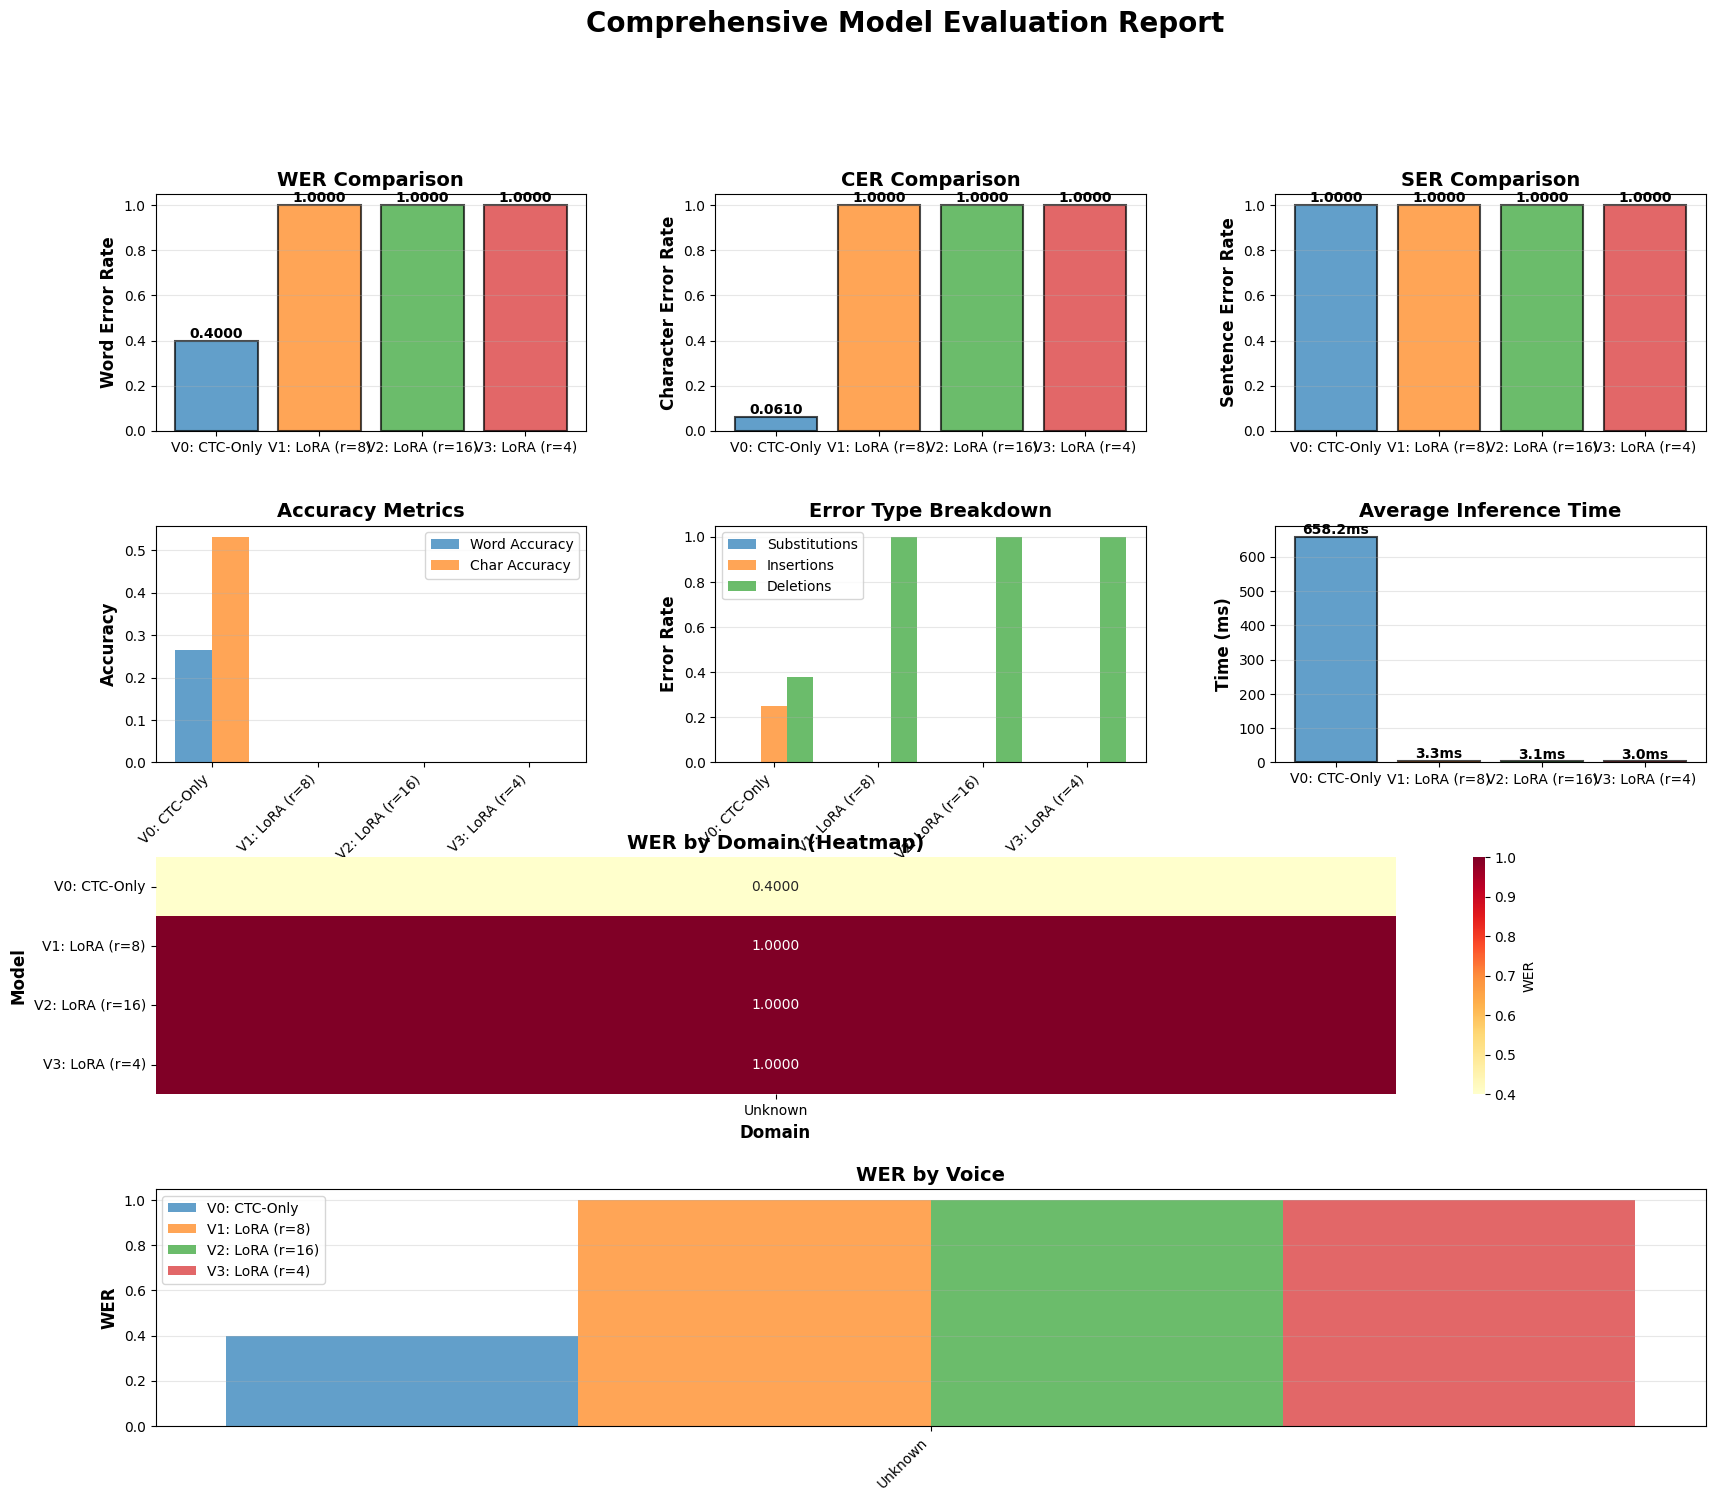


Evaluation report saved to: comprehensive_evaluation_report.png


In [18]:
# Create comprehensive visualization report
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# 1. Overall WER Comparison
ax1 = fig.add_subplot(gs[0, 0])
model_names = [MODEL_LABELS[k] for k in models.keys()]
wer_values = [all_metrics[k]['wer'] for k in models.keys()]
colors = [MODEL_COLORS[k] for k in models.keys()]
bars = ax1.bar(model_names, wer_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Word Error Rate', fontsize=12, fontweight='bold')
ax1.set_title('WER Comparison', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, wer_values):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Overall CER Comparison
ax2 = fig.add_subplot(gs[0, 1])
cer_values = [all_metrics[k]['cer'] for k in models.keys()]
bars = ax2.bar(model_names, cer_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Character Error Rate', fontsize=12, fontweight='bold')
ax2.set_title('CER Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, cer_values):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. SER Comparison
ax3 = fig.add_subplot(gs[0, 2])
ser_values = [all_metrics[k]['ser'] for k in models.keys()]
bars = ax3.bar(model_names, ser_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Sentence Error Rate', fontsize=12, fontweight='bold')
ax3.set_title('SER Comparison', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, ser_values):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Accuracy Metrics
ax4 = fig.add_subplot(gs[1, 0])
word_accs = [all_metrics[k]['word_accuracy'] for k in models.keys()]
char_accs = [all_metrics[k]['char_accuracy'] for k in models.keys()]
x = np.arange(len(model_names))
width = 0.35
bars1 = ax4.bar(x - width/2, word_accs, width, label='Word Accuracy', alpha=0.7)
bars2 = ax4.bar(x + width/2, char_accs, width, label='Char Accuracy', alpha=0.7)
ax4.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('Accuracy Metrics', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(model_names, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Error Breakdown (Sub/Ins/Del)
ax5 = fig.add_subplot(gs[1, 1])
subs = [all_metrics[k]['substitution_rate'] for k in models.keys()]
ins = [all_metrics[k]['insertion_rate'] for k in models.keys()]
dels = [all_metrics[k]['deletion_rate'] for k in models.keys()]
x = np.arange(len(model_names))
width = 0.25
bars1 = ax5.bar(x - width, subs, width, label='Substitutions', alpha=0.7)
bars2 = ax5.bar(x, ins, width, label='Insertions', alpha=0.7)
bars3 = ax5.bar(x + width, dels, width, label='Deletions', alpha=0.7)
ax5.set_ylabel('Error Rate', fontsize=12, fontweight='bold')
ax5.set_title('Error Type Breakdown', fontsize=14, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(model_names, rotation=45, ha='right')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Inference Speed
ax6 = fig.add_subplot(gs[1, 2])
inf_times = [all_metrics[k]['avg_inference_time'] * 1000 for k in models.keys()]  # Convert to ms
bars = ax6.bar(model_names, inf_times, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
ax6.set_title('Average Inference Time', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, inf_times):
    ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.1f}ms', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 7. Per-Domain WER Heatmap
ax7 = fig.add_subplot(gs[2, :])
domain_wer_data = []
for model_key in models.keys():
    row = []
    for domain in sorted(test_df['domain'].unique()):
        if domain in domain_metrics[model_key]:
            row.append(domain_metrics[model_key][domain]['wer'])
        else:
            row.append(np.nan)
    domain_wer_data.append(row)
domain_wer_df = pd.DataFrame(domain_wer_data, 
                            index=[MODEL_LABELS[k] for k in models.keys()],
                            columns=sorted(test_df['domain'].unique()))
sns.heatmap(domain_wer_df, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax7, cbar_kws={'label': 'WER'})
ax7.set_title('WER by Domain (Heatmap)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Domain', fontsize=12, fontweight='bold')
ax7.set_ylabel('Model', fontsize=12, fontweight='bold')

# 8. Per-Voice WER Comparison
ax8 = fig.add_subplot(gs[3, :])
voice_wer_data = {}
for model_key in models.keys():
    voice_wers = []
    voice_labels = []
    for voice in sorted(test_df['voice'].unique()):
        if voice in voice_metrics[model_key]:
            voice_wers.append(voice_metrics[model_key][voice]['wer'])
            voice_labels.append(voice)
    voice_wer_data[MODEL_LABELS[model_key]] = voice_wers

x = np.arange(len(sorted(test_df['voice'].unique())))
width = 0.2
for i, (label, wers) in enumerate(voice_wer_data.items()):
    offset = (i - len(voice_wer_data)/2) * width + width/2
    ax8.bar(x + offset, wers, width, label=label, alpha=0.7)
ax8.set_ylabel('WER', fontsize=12, fontweight='bold')
ax8.set_title('WER by Voice', fontsize=14, fontweight='bold')
ax8.set_xticks(x)
ax8.set_xticklabels(sorted(test_df['voice'].unique()), rotation=45, ha='right')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

fig.suptitle('Comprehensive Model Evaluation Report', fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# Save plot
fig.savefig('comprehensive_evaluation_report.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\nEvaluation report saved to: comprehensive_evaluation_report.png")


## 12. Summary Table

In [19]:
# Create comprehensive summary table
summary_data = []
for model_key in models.keys():
    summary_data.append({
        'Model': MODEL_LABELS[model_key],
        'WER': f"{all_metrics[model_key]['wer']:.4f}",
        'CER': f"{all_metrics[model_key]['cer']:.4f}",
        'SER': f"{all_metrics[model_key]['ser']:.4f}",
        'Word Accuracy': f"{all_metrics[model_key]['word_accuracy']:.4f}",
        'Char Accuracy': f"{all_metrics[model_key]['char_accuracy']:.4f}",
        'Sub Rate': f"{all_metrics[model_key]['substitution_rate']:.4f}",
        'Ins Rate': f"{all_metrics[model_key]['insertion_rate']:.4f}",
        'Del Rate': f"{all_metrics[model_key]['deletion_rate']:.4f}",
        'Avg Confidence': f"{all_metrics[model_key]['avg_confidence']:.4f}",
        'Inf Time (ms)': f"{all_metrics[model_key]['avg_inference_time']*1000:.2f}"
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*120)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*120)
print(summary_df.to_string(index=False))
print("="*120)

# Save to CSV
summary_df.to_csv('evaluation_summary.csv', index=False)
print("\nSummary saved to: evaluation_summary.csv")



COMPREHENSIVE EVALUATION SUMMARY
          Model    WER    CER    SER Word Accuracy Char Accuracy Sub Rate Ins Rate Del Rate Avg Confidence Inf Time (ms)
   V0: CTC-Only 0.4000 0.0610 1.0000        0.2647        0.5321   0.0000   0.2505   0.3786         0.9838        658.25
 V1: LoRA (r=8) 1.0000 1.0000 1.0000        0.0000        0.0000   0.0000   0.0000   1.0000         0.0000          3.31
V2: LoRA (r=16) 1.0000 1.0000 1.0000        0.0000        0.0000   0.0000   0.0000   1.0000         0.0000          3.07
 V3: LoRA (r=4) 1.0000 1.0000 1.0000        0.0000        0.0000   0.0000   0.0000   1.0000         0.0000          3.04

Summary saved to: evaluation_summary.csv


## 13. Detailed Results Export

In [20]:
# Export detailed results for each model
for model_key in models.keys():
    detailed_results = test_df.copy()
    detailed_results['prediction'] = results[model_key]['predictions']
    detailed_results['confidence'] = results[model_key]['confidences']
    detailed_results['inference_time'] = results[model_key]['inference_times']
    
    # Compute per-sample metrics
    detailed_results['wer'] = [
        compute_wer_metrics(ref, hyp)['wer'] 
        for ref, hyp in zip(detailed_results['transcription'], detailed_results['prediction'])
    ]
    detailed_results['cer'] = [
        compute_cer(ref, hyp) 
        for ref, hyp in zip(detailed_results['transcription'], detailed_results['prediction'])
    ]
    detailed_results['ser'] = [
        compute_ser(ref, hyp) 
        for ref, hyp in zip(detailed_results['transcription'], detailed_results['prediction'])
    ]
    
    # Save
    output_file = f"detailed_results_{model_key}.csv"
    detailed_results.to_csv(output_file, index=False)
    print(f"Detailed results saved: {output_file}")

print("\nAll detailed results exported!")


Detailed results saved: detailed_results_V0_CTC_Only.csv
Detailed results saved: detailed_results_V1_Base.csv
Detailed results saved: detailed_results_V2_Higher.csv
Detailed results saved: detailed_results_V3_Lower.csv

All detailed results exported!
